<a href="https://colab.research.google.com/github/Amine-aab/Pytorch-UNet/blob/master/Unet_kantenExtraktion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install patchify
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import normalize
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras import backend as K

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
seed=24
batch_size= 2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=0,
                      width_shift_range=0,
                      height_shift_range=0.1,
                      shear_range=0,
                      zoom_range=0,
                      horizontal_flip=True ,
                      vertical_flip=False,
                      #fill_mode='reflect'
                      )

mask_data_gen_args = dict(rescale = 1,  ### rescaling to 0 to 1 !!!!!!!!!
                        rotation_range=0,
                      width_shift_range=0,
                      height_shift_range=0.1,
                      shear_range=0,
                      zoom_range=0,
                      horizontal_flip=True,
                      vertical_flip=False,
                      #fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

In [113]:
!pip install split-folders
import splitfolders
input_folder = '/content/drive/MyDrive/MasterArbeit/Daten2/'
splitfolders.ratio(input_folder, output="data3", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 1020 files [00:06, 147.46 files/s]


In [114]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)

image_generator = image_data_generator.flow_from_directory("data3/train_images/", target_size=(1024,1216),
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           color_mode = 'grayscale',
                                                           class_mode=None)   

Found 408 images belonging to 1 classes.


In [115]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

mask_generator = mask_data_generator.flow_from_directory("data3/train_masks", target_size=(1024,1216),
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

Found 408 images belonging to 1 classes.


In [116]:
valid_img_generator = image_data_generator.flow_from_directory("data3/val_images/", target_size=(1024,1216),
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',
                                                               class_mode=None) #Default batch size 32, if not specified here

valid_mask_generator = mask_data_generator.flow_from_directory("data3/val_masks/",  target_size=(1024,1216), 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here

Found 51 images belonging to 1 classes.
Found 51 images belonging to 1 classes.


In [117]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

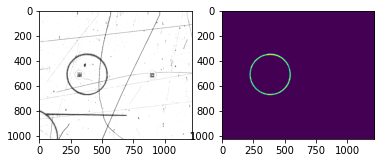

In [118]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [119]:
def dice_metric(y_pred, y_true):
  
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0
    dice= 2*intersection / union
    return dice

In [120]:
dice= dice_metric

In [121]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

In [122]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [123]:
# Building Unet by dividing encoder and decoder into blocks

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [124]:
model=build_unet(input_shape)

In [125]:
#!pip install focal_loss
#from focal_loss import BinaryFocalLoss

optimizer= tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = False)

model.compile(optimizer, 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[dice_metric])

In [126]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1024, 1216,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_95 (Conv2D)             (None, 1024, 1216,   640         ['input_6[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_90 (BatchN  (None, 1024, 1216,   256        ['conv2d_95[0][0]']              
 ormalization)                  64)                                                           

In [127]:
num_train_imgs = len(os.listdir('data3/train_images/images/'))
num_train_imgs

408

In [128]:
steps_per_epoch = num_train_imgs //batch_size
steps_per_epoch

204

In [129]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [130]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [131]:
gpu_opts = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_opts))

In [ ]:
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch, epochs=300, 
                    validation_steps= steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/300
204/204 [==============================] - 357s 2s/step - loss: 0.0609 - dice_metric: 0.1197 - val_loss: 0.0470 - val_dice_metric: 0.0072
Epoch 2/300
204/204 [==============================] - 351s 2s/step - loss: 0.0330 - dice_metric: 0.2087 - val_loss: 0.0440 - val_dice_metric: 0.0176
Epoch 3/300
204/204 [==============================] - 352s 2s/step - loss: 0.0305 - dice_metric: 0.2303 - val_loss: 0.0396 - val_dice_metric: 0.0618
Epoch 4/300
204/204 [==============================] - 351s 2s/step - loss: 0.0264 - dice_metric: 0.2952 - val_loss: 0.0504 - val_dice_metric: 0.1440
Epoch 5/300
204/204 [==============================] - 351s 2s/step - loss: 0.0275 - dice_metric: 0.3016 - val_loss: 0.0816 - val_dice_metric: 0.1661
Epoch 6/300
204/204 [==============================] - 352s 2s/step - loss: 0.0250 - dice_metric: 0.3267 - val_loss: 0.0408 - val_dice_metric: 0.1630
Epoch 7/300
182/204 [=========================>....] - ETA: 26s - loss: 0.0244 - dice_metric: 0.3505

In [ ]:
model.save('/content/drive/MyDrive/MasterArbeit/Ergebnisse/Unet_KantenExtraktion_1024_1216_SGD_lr_0.01.hdf5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['dice_metric']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_metric']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/MasterArbeit/Ergebnisse/Unet_KantenExtraktion_1024_1216_SGD_lr_0.01.hdf5", compile=False)

test_img_generator = image_data_generator.flow_from_directory("data3/test_images/", target_size=(512,608),
                                                              seed=seed, 
                                                              batch_size=16, color_mode = 'grayscale',
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("data3/test_masks/", target_size=(512,608),
                                                              seed=seed, 
                                                              batch_size=16, 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here


In [ ]:
### Testing on a few test images

a = test_img_generator.next()
b = test_mask_generator.next()
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(20, 18))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


In [ ]:
#Calculate IoU and average
 
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

In [ ]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
#df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU) 